<img src="../imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## 1.3 Evolutionary Algorithms

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

## Outline

1. [Individuals](#individuals)
2. [Objectives](#objectives)
3. [(1+1) EA](#one_plus_one)
4. [$(1+\lambda)$ EA](#one_plus_lambda)
5. [Continuous Optimization](#continuous)
6. [Algorithm parameters](#parameters)

In [1]:
using Plots
using Random
using Statistics

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


## <a id="individuals"></a>Individuals

The base unit of an evolutionary algorithm is the individual. An individual represents a single solution to the problem we want to solve. We'll start simple with binary individuals, where genes are represented by bits. DNA in biological organisms is mostly base 4, being represented by 4 different amino acids. We'll use a base 2 representation of 1s and 0s, but the interpretation of these binary strings could lead to any complex organism. Using binary strings allows us to discuss the theoretical analysis of evolutionary algorithms, which have mostly been studied on binary genomes.

In [59]:
mutable struct Individual
    genes::BitArray
    fitness::Int64
end

function Individual(n::Int64)
    Individual(bitrand(n), 0)
end

n = 20
ind = Individual(n)

Individual(Bool[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 0)

Here we've defined a new type, `Individual` which has binary genes and an integer fitness. When we construct a new individual, we use random genes and set the default fitness to 0. For these examples we'll be using objective functions which have positive fitness values.

## <a id="objectives"></a>Objectives

An objective function is a function which gives a value to our individual. A strength of evolutionary algorithms is that this objective function can be anything as long as it evaluates the individual. Unlike other optimization methods, this function does not need to be differentiable or continuous. The first objective function we'll look at is the OneMax function, which simply adds all of the bits of the genotype. The optimal fitness for this function is therefore when the entire genotype is 1. This simple function has been well-studied and generalizes well to the search of any specific bit string.

In [60]:
function onemax(ind::Individual)
    sum(ind.genes)
end

ind, onemax(ind)

(Individual(Bool[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 0), 5)

As we can see, the fitness of our individual is the number of 1s in the function.

In order to be more general later, we'll write an `evaluate` function which can take any `objective` function. The `!` exclamation point in `evaluate!` indicates that this function modifies the object which is passed. 

In [61]:
function evaluate!(ind::Individual, objective::Function)
    ind.fitness = objective(ind)
end

evaluate!(ind, onemax)
ind

Individual(Bool[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 5)

Now that we have our individuals defined and we have an objective function, we're ready to write our first evolutionary algorithm.

## <a id="one_plus_one"></a>(1+1) Evolutionary Algorithm

The first algorithm we'll implement is the simplest evolutionary algorithm, the (1+1) Evolutionary Algorithm:

1. Choose randomly an initial bit string $x∈ \{0;1\} $
2. Repeat the following mutation step:
    1. Compute $x′$ by flipping independently each bit $x_i$ with probability $p$
    2. Replace $x$ by $x′$ if $f(x′) \geq f(x)$.

We'll start by defining the first random individual

In [202]:
parent = Individual(n)
evaluate!(parent, onemax) 

11

Let's define the mutation step as a function. This will make our code more organized and has the advantage in Julia that compilation will optimize this part of the code. We'll use the probability of $p=\frac{1}{n}$, where $n$ is the number of bits. We'll discuss that choice soon.

In [115]:
function mutate(ind::Individual; mutation_rate::Float64=1.0/length(ind.genes))
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = ~ind.genes[i]
        end
    end
    Individual(new_genes, 0)
end

mutate (generic function with 2 methods)

In [203]:
child = mutate(parent)
evaluate!(child, onemax)
print(parent.genes .== child.genes)

Bool[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Try running this a few times and you'll see that most of the time, only one gene changes. That makes sense due to the $p=\frac{1}{n}$ mutation rate we set. This means that evolution will move rather slowly towards the optimal bitstring, on average only 1 change at a time.

Now that we have the new individual, we can do the last part of our algorithm: Replace $x$ by $x′$ if $f(x′) \geq f(x)$.

In [204]:
if child.fitness >= parent.fitness
    parent = child
end
parent.fitness

12

That's all there is to the (1+1) EA. We simply run this mutation step over and over until we reach the solution we want or stop the computation. Let's look at just a few iterations:

In [221]:
for i in 1:5
    child = mutate(parent)
    evaluate!(child, onemax)
    if child.fitness >= parent.fitness
        parent = child
    end
end

print(parent.fitness, " / ", n)

19 / 20

So in a few generations, we can see improvement. To study how long it will take for this to reach the OneMax solution, let's first define everything we've done until now as a function.

In [10]:
function one_plus_one(ind_length::Int, num_generations::Int, f::Function)
    fits = zeros(num_generations)
    parent = Individual(ind_length)
    evaluate!(parent, f)
    
    for i in eachindex(fits)
        child = mutate(parent)
        evaluate!(child, f)

        if child.fitness >= parent.fitness
            parent = child
        end

        fits[i] = parent.fitness
    end
    fits
end

one_plus_one (generic function with 1 method)

Since evolutionary algorithms are stochastic, it's hard to guarantee their exact computational complexity. You can prove the worst case, but a more useful metric is the expected number of generations to reach the optimal solution. For linear objective functions such as the OneMax problem, the expected runtime for the (1+1) EA has been [proven](https://core.ac.uk/download/pdf/82100186.pdf) to to be $0(n \log n)$, where $n$ is the number of independent binary variables (ie, the length of the genome). This proof is beyond the scope of this class, but I recommend looking at the linked publications in this notebook. Note that this is only for the case of a mutation rate of $\frac{1}{n}$, which is why we used it as our default value before. 

Let's run our (1+1) EA with $n \log n$ as our number of generations.

969.0


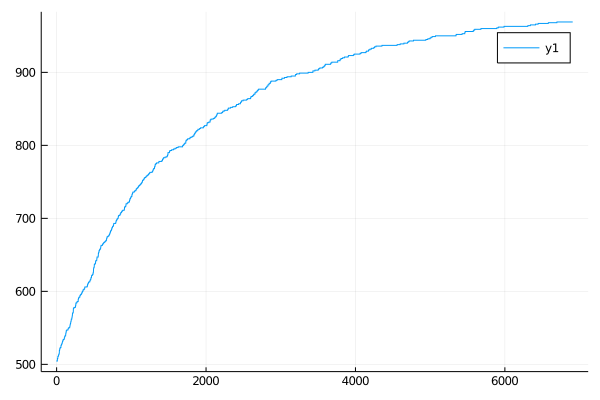

In [11]:
n = 1000
fits = one_plus_one(n, Int(round(n * log(n))), onemax)
println(fits[end])
plot(fits)

This isn't yet $n$ but its very close, which is what the expected time guarantees: $n \log n$ is the average value of when the (1+1) EA converges. The worst case for a binary (1+1) EA on any function is to converge in $O(n^n)$, but we don't need to run it for that long to see convergence.

1000.0


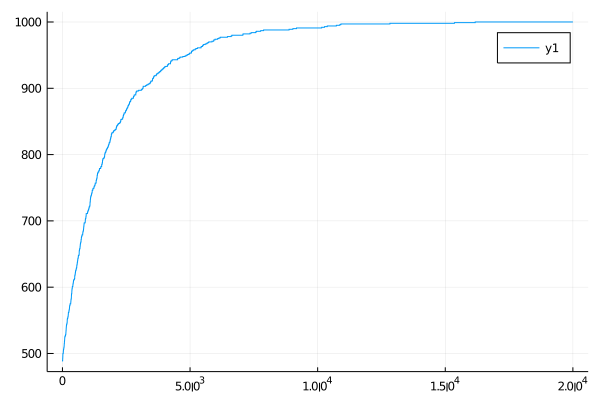

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [12]:
n = 1000
fits = one_plus_one(n, 20000, onemax)
println(fits[end])
plot(fits)

The Leading Ones problem is another well-studied binary problem which counts the number of leading ones from left to right, stopping when the first zero-bit is found. In other words, the fitness of this function is:

$f(x) := \sum_{i=1}^n \prod_{j=1}^1 x_j$

In our implementation, we'll just count the indices and stop when we reach a 0.

In [13]:
function leading_ones(ind::Individual)
    f = 0
    for i in eachindex(ind.genes)
        if ~ind.genes[i]
            f = i-1
            break
        end
    end
    f
end

leading_ones(ind)

0

<div class="alert alert-success">
    <b>Exercise</b>
    <br/>
    Run the (1+1) EA on the Leading Ones problem. Does it converge near $0(n \log n)$, or $O(n^2)$?
    <br/>
</div>

## <a id="one_plus_lambda"></a>$(1+\lambda)$ Evolutionary Algorithm

The next algorithm that we'll see is a small change on the (1+1) EA. Instead of generating one individual each iteration (generation) we'll make $\lambda$. This can be considered our population. This small change means the $(1+\lambda)$ algorithm is still very simple, but this simple algorithm is used in state-of-the-art Genetic Programming methods to do perform complex tasks.

The $(1+\lambda) EA$ introduces a new parameter: population size. What should we choose for this parameter? [Recent theoretical work](https://www.sciencedirect.com/science/article/pii/S0304397514002060) has demonstrated that the expected running time of the $(1+\lambda)$ EA on any linear function is $O(\frac{1}{λ} n \log n + n)$ under the condition that $\lambda = O(\log n \log \log n / \log \log \log n)$. We could try that.

In [14]:
n = 100
𝜆 = Int(round(log(n)log(log(n))/log(log(log(n)))))

17

But let's keep things simple and just use 10.

In [15]:
𝜆 = 10

10

We'll rewrite our `one_plus_one` function, this time using a population of individuals. We'll keep track of the best new individual in order to compare it with the expert for replacement in the next generation.

In [16]:
function one_plus_lambda(ind_length::Int, num_generations::Int, f::Function, 𝜆::Int)
    
    fits = zeros(num_generations)
    expert = Individual(ind_length)
    evaluate!(expert, f)
    
    for i in eachindex(fits)
        population = Array{Individual}(undef, 𝜆)
        best = 1
        for j in eachindex(population)
            population[j] = mutate(expert)
            evaluate!(population[j], f) 
            if population[j].fitness > population[best].fitness
                best = j
            end
        end
        
        if population[best].fitness >= expert.fitness
            expert = population[best]
        end

        fits[i] = expert.fitness
    end
    fits
end

one_plus_lambda (generic function with 1 method)

Let's see how these two methods compare on the OneMax problem.

In [17]:
n = 100
n_gens = 1000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, n_gens, onemax, 𝜆)
fits_1[end], fits_𝜆[end]

(98.0, 100.0)

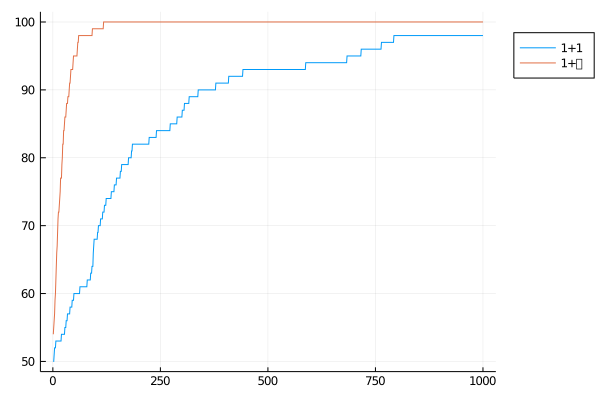

In [18]:
plot(fits_1, label="1+1", legend=:outertopright)
plot!(fits_𝜆, label="1+𝜆")

At first glance, it appears that the $(1+\lambda)$ EA performs much better than the (1+1) EA. However, this is an unfair comparison. The $(1+\lambda)$ EA runs the evaluation function $\lambda$ times per generation, meaning there are many more evaluations. We can see this by plotting based on evaluation.

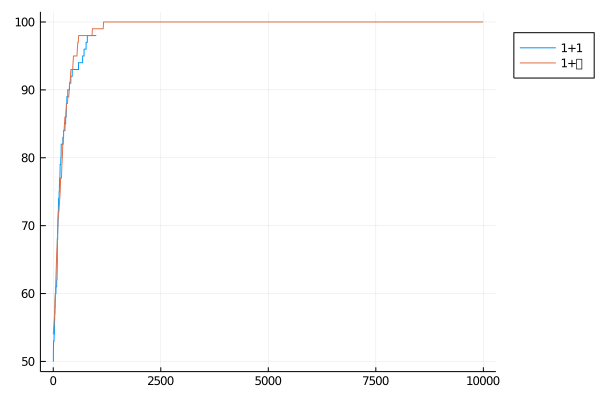

In [19]:
plot(fits_1, label="1+1", legend=:outertopright)
plot!(1:𝜆:𝜆*n_gens, fits_𝜆, label="1+𝜆")

A more fair comparison would be to give each algorithm the same number of function evaluations, like this:

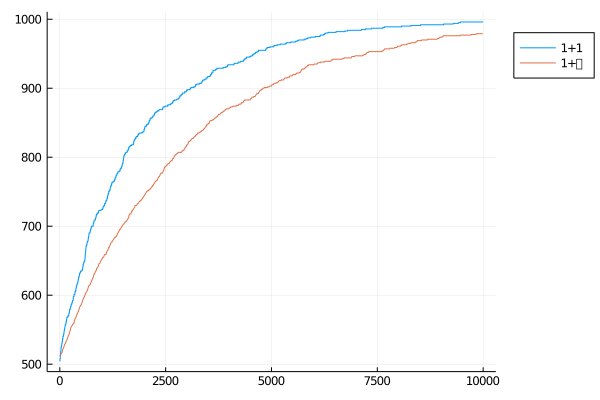

In [20]:
n = 1000
n_gens = 10000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, Int(n_gens/𝜆), onemax, 𝜆)
plot(fits_1, label="1+1", legend=:outertopright)
plot!(1:𝜆:n_gens, fits_𝜆, label="1+𝜆")

Because evolutionary algorithms are entirely based on randomness, it is a good practice to run them multiple times to have an idea about their performance. We'll run this 10 times, but more is often a good idea, depending on the distribution of final results.

In [21]:
n_trials = 10
n = 100
n_gens = 1000

fits_1 = zeros(n_gens, n_trials)
fits_𝜆 = zeros(Int(n_gens/𝜆), n_trials)

for i in 1:n_trials
    fits_1[:, i] = one_plus_one(n, n_gens, onemax)
    fits_𝜆[:, i] = one_plus_lambda(n, Int(n_gens/𝜆), onemax, 𝜆)
end

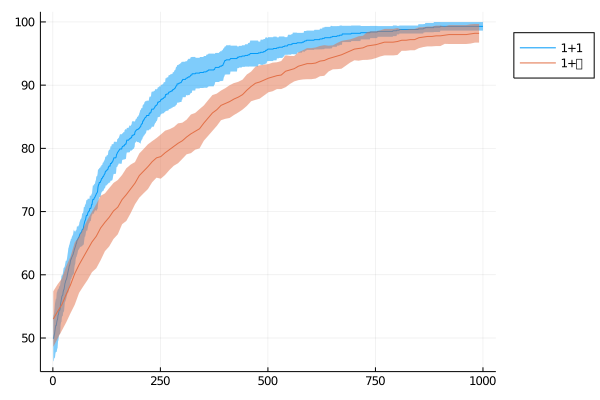

In [22]:
μ_1 = mean(fits_1, dims=2)
σ_1 = std(fits_1, dims=2)
μ_𝜆 = mean(fits_𝜆, dims=2)
σ_𝜆 = std(fits_𝜆, dims=2)
plot(1:n_gens, μ_1, ribbon=σ_1, label="1+1", legend=:outertopright)
plot!(1:𝜆:n_gens, μ_𝜆, ribbon=σ_𝜆, label="1+𝜆")

<div class="alert alert-success">
    <b>Exercise</b>
    <br/>
    Compare the (1+1) EA and $(1+\lambda)$ EA on the Leading Ones problem
    <br/>
</div>

## <a id="continuous"></a>Continuous optimization

So far we've looked at the case of binary functions. However, these algorithms can be used for any objective function and genotype definition. Let's look at the case of continuous optimization, which optimized over real numbers. For that, we'll need to define a new Individual type. Instead of random bits, this individual will have random numbers for its genes. We'll look at the case of uniformly distributed random numbers between 0 and 1.

In [222]:
mutable struct FloatIndividual
    genes::Array{Float64}
    fitness::Float64
end

function FloatIndividual(n::Int64)
    FloatIndividual(rand(n), -Inf)
end

n = 10
ind = FloatIndividual(n)

FloatIndividual([0.8189746930020587, 0.5411066523039167, 0.13527514202301316, 0.5462799398013802, 0.7118066554024898, 0.7984983701166157, 0.7705967570461121, 0.7285246588246548, 0.3898552394272974, 0.020286805681509534], -Inf)

We also need to define a new mutation function. Instead of flipping bits, we'll just draw a new random number.

In [226]:
function mutate(ind::FloatIndividual; mutation_rate::Float64=1.0/length(ind.genes))
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = rand()
        end
    end
    FloatIndividual(new_genes, 0)
end

child = mutate(ind)
print(ind.genes .== child.genes)

Bool[1, 1, 1, 1, 1, 0, 1, 1, 1, 1]

One of the most classic continuous optimization problems is the sphere function. This function simply gives the distance from an optimal point in all dimensions.

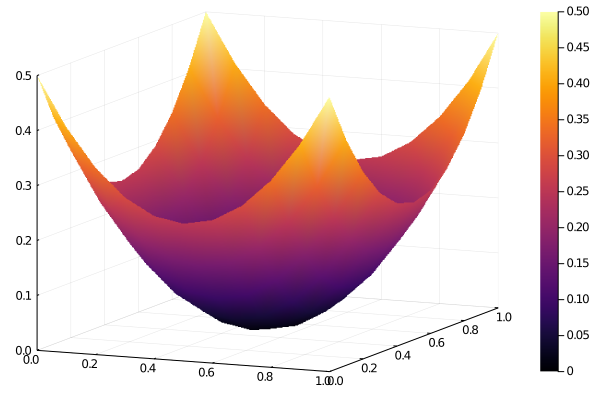

In [227]:
x = 0:0.1:1.0
y = 0:0.1:1.0
fz(x, y) = (x-0.5)^2 + (y-0.5)^2
plot(x, y, fz, st=:surface)

In [241]:
function sphere(ind::FloatIndividual; center::Float64=0.5)
    f = 0
    for g in ind.genes
        f += (g - center)^2
    end
    -f
end

sphere(ind)

-0.7402667444284756

<div class="alert alert-success">
    <b>Exercise</b>
    <br/>
    Use the <tt>FloatIndividual</tt> to compare the (1+1) EA and $(1+\lambda)$ EA on the sphere problem. You'll need to change the definition of <tt>one_plus_one</tt> and <tt>one_plus_lambda</tt> to use the <tt>FloatIndividual</tt> type.
    <br/>
</div>

## <a id="parameters"></a>Algorithm parameters

In this tutorial, we used fixed parameter values based on theoretical results. However, in practice, the choice of mutation rate and population size can greatly impact experimental results. Recent work has also demonstrated the value in [self-adjusting parameters](https://arxiv.org/pdf/1704.02191.pdf), which is similar to what a different stochastic optimization method, simulated annealing, uses. The policy of parameter adjustment is still an active field of research.

<div class="alert alert-info">
    <b>Bonus Exercise</b>
    <br/>
    Study the effect of population size $\lambda$ and mutation rate on $(1+1)$ EA and $(1+\lambda)$ EA. Do they change the results a lot? Try implementing a dynamic mutation rate, such as one that decreases over time.
    <br/>
</div>